# RNN - Model

In [1]:
# DATA MANIPULATION, Visualization, and stats
import pandas as pd
from glob import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Your current working directory should be ./mattwagon/oil_production_prediction/notebooks
os.getcwd()

'/Users/eduardomonteiro/code/mattwagon/oil_production_prediction/notebooks'

## Import the data

In [3]:
# This filepath should work for all of us
# I have added 'raw_data' to .gitignore so it should never be pushed to the repo
path = os.path.join('..', 'raw_data')
file_names = os.listdir(path)
csv_files = [f for f in file_names if f.endswith('.csv')]

csv_files.sort()

df = pd.DataFrame()

for file in csv_files:
    file_path = os.path.join(path, file)
    df_aux = pd.read_csv(file_path)
    df = pd.concat([df, df_aux], ignore_index=True)

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.tz_convert(None)
df['Date'] = pd.to_datetime(df['Date'].apply(lambda x: x + pd.DateOffset(hours=1)))

In [5]:
df.head()

,Date,Calculated Drawdown_At Gauge,Calculated Drawdown_At Bottom Node,Reservoir Pressure,z Well Identifier,z TMore PS Identifier,z TMore Identifier,z Tag Identifier 2,z Tag Identifier,z PI-AF Database,...,Annulus Master Valve Status,Annulus Master Valve Opening Frequency,Pseudo Cv,GL GOR,GL Qgas,GL Qliq,GL Qoil,GL Qwat,GL Ramp-up Speed,GL WCT
0,2007-02-01,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08
1,2007-02-02,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08
2,2007-02-03,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08
3,2007-02-04,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08
4,2007-02-05,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08


## Data cleaning

### Drop features with more than 30% NaN values

In [6]:
features_nan_drop = []

for feature, value in dict(df.isnull().sum().sort_values(ascending=False)).items():
    if value/len(df) > 0.3:
        features_nan_drop.append(feature)
        
df.drop(columns=features_nan_drop, inplace=True)

In [7]:
df.shape

(5813, 65)

### Drop features with std = 0

In [8]:
features_null_std = []

for feature in df.drop(columns='Date').columns:
    if df[feature].std() < 0.0000001:
        features_null_std.append(feature)
        
df.drop(columns=features_null_std, inplace=True)

In [9]:
df.shape

(5813, 41)

### Drop corrected features

In [10]:
corrected_features_drop = ['Qwat MPFM corrected', 'Qoil MPFM corrected', 'Qliq MPFM corrected', 'Qgas MPFM corrected']
df.drop(columns=corrected_features_drop, inplace=True)

### Drop choke features

In [11]:
choke_features_drop = ['Choke Opening Calc1', 'Choke Opening Calc2', 'Choke Measured', 'Choke Calculated', 'Choke CCR']
df.drop(columns=choke_features_drop, inplace = True)

### Drop correlated features

In [12]:
features_corr_drop = ['Qwat PC', 'Qgas PC', 'Qoil PC', 'Tubing dP','MPFM P', 'Qliq MPFM', 'Qwat MPFM']
df.drop(columns=features_corr_drop, inplace = True)

### Drop features in remove dictionary

In [13]:
remove = {"Sand Rate", "MPFM NTotal Count Rate", "MPFM N81 Count Rate", "MPFM N356 Count Rate", "MPFM N32 Count Rate", "MPFM GOR", "Downhole Gauge T", "Downhole Gauge P"}

In [14]:
df.drop(columns=remove, inplace=True)

## Impute features with <30% NaN values

In [15]:
for feature in df.columns:
    df[feature].replace(np.nan, df[feature].median(), inplace=True)

In [16]:
df.isnull().sum()

Date               0
WHT                0
WHP                0
Tubing Gradient    0
Service Line P     0
Sand Raw           0
Qoil MPFM          0
Qgas MPFM          0
MPFM WCT           0
MPFM Venturi dP    0
MPFM T             0
MPFM CF GOR        0
Manifold T         0
Manifold P         0
Jumper T           0
Choke Opening      0
Annulus P          0
dtype: int64

## Visualising the Time Series

In [30]:
TARGET = 'Qoil MPFM'
N_TARGETS = 1
N_FEATURES = df.shape[1] - 1

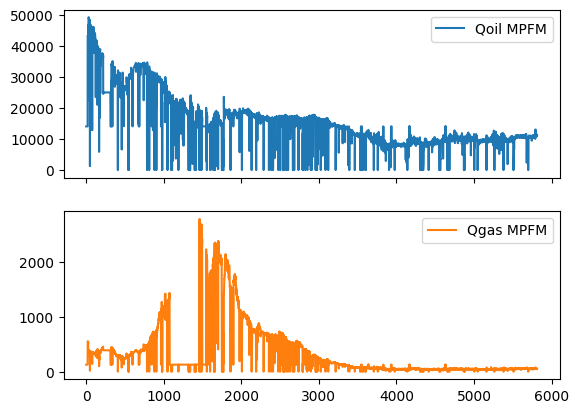

In [18]:
plot_cols = [TARGET, 'Qgas MPFM']
plot_features = df[plot_cols]
plot_features.index = df.index
plot_features.plot(subplots = True);

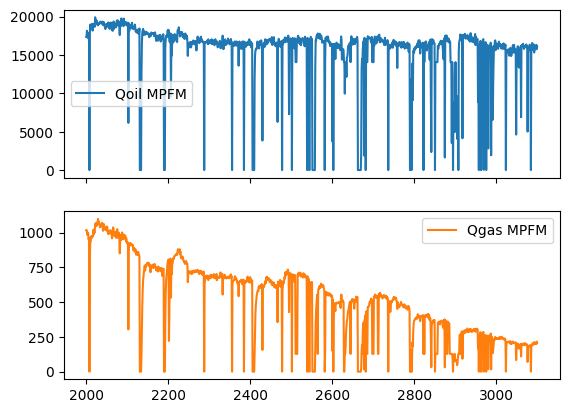

In [19]:
zoomed_slice = slice(2000,3100)

plot_features = df.loc[zoomed_slice, plot_cols]
plot_features.plot(subplots = True);

## Prepare the dataset

### The big picture

Step 1: Cross validation in time series (folds):
    - we'll create folds and train/evaluate our LSTM on these different folds about the robustness of the neural network

Step 2: Holdout method within each fold (train-test-split) to:
    - fit the model on the train set;
    - and evaluate it on the test set;
    - always split the train set chronologically before the test set
    
Step 3: Sampling sequences in both the train set and the test set

### Creating folds for cross-validation

In [20]:
# --------------------------------------------------- #
# Let's consider FOLDS with a length of 3 years       #
# (2 years will be used for train, 1 for test!)       #
# --------------------------------------------------- #

FOLD_LENGTH = 365 * 3 # three years

# --------------------------------------------------- #
# Let's consider FOLDS starting every trimester       #
# --------------------------------------------------- #
    
FOLD_STRIDE = 91 # 1 quarter = 91 days

# --------------------------------------------------- #
# Let's consider a train-test-split ratio of 2/3      #
# --------------------------------------------------- #

TRAIN_TEST_RATIO = 0.66

In [21]:
def get_folds(
    df: pd.DataFrame,
    fold_length: int,
    fold_stride: int) -> list[pd.DataFrame]:
    '''
    This function slides through the Time Series dataframe of shape (n_timesteps, n_features) to create folds
    - of equal `fold_length`
    - using `fold_stride` between each fold
    
    Returns a list of folds, each as a DataFrame
    '''
    fold_list = []
    
    
    for i in range(0, len(df), fold_stride):
        if i + fold_length >= len(df):
            break
        fold_list.append(df[i:fold_length])
    
    return fold_list

In [22]:
folds = get_folds(df, FOLD_LENGTH, FOLD_STRIDE)

print(f'The function generated {len(folds)} folds.')
print(f'Each fold has a shape equal to {folds[0].shape}.')

The function generated 52 folds.
Each fold has a shape equal to (1095, 17).


### Temporal Train/Test Split

Focus on 1 fold for the moment:

In [23]:
fold = folds[0]
fold

,Date,WHT,WHP,Tubing Gradient,Service Line P,Sand Raw,Qoil MPFM,Qgas MPFM,MPFM WCT,MPFM Venturi dP,MPFM T,MPFM CF GOR,Manifold T,Manifold P,Jumper T,Choke Opening,Annulus P
0,2007-02-01,51.247467,78.146263,0.000000,109.413887,5084.182129,14065.431937,127.717811,0.000000,1672.997986,52.371239,1.0,51.940947,69.046879,51.085567,76.917267,150.246353
1,2007-02-02,51.247467,78.146263,0.000000,109.413887,5084.182129,14065.431937,127.717811,0.000000,1672.997986,52.371239,1.0,51.940947,69.046879,51.085567,76.917267,150.246353
2,2007-02-03,51.247467,78.146263,0.000000,109.413887,5084.182129,14065.431937,127.717811,0.000000,1672.997986,52.371239,1.0,51.940947,69.046879,51.085567,76.917267,150.246353
3,2007-02-04,51.247467,78.146263,0.000000,109.413887,5084.182129,14065.431937,127.717811,0.000000,1672.997986,52.371239,1.0,51.940947,69.046879,51.085567,76.917267,150.246353
4,2007-02-05,51.247467,78.146263,0.000000,109.413887,5084.182129,14065.431937,127.717811,0.000000,1672.997986,52.371239,1.0,51.940947,69.046879,51.085567,76.917267,150.246353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,2010-01-26,48.246864,93.970413,0.692401,104.580345,4832.562500,23788.793743,127.717811,16.810093,5000.000000,47.968342,1.0,47.503666,60.694332,45.013710,75.156860,106.314453
1091,2010-01-27,48.226227,94.041245,0.691799,105.844513,4839.964844,23831.706038,127.717811,16.221851,5000.000000,47.933216,1.0,47.438766,60.450886,44.930332,75.275383,106.136719
1092,2010-01-28,48.231678,97.257195,0.673693,103.679131,4775.291016,22478.727202,127.717811,17.043915,4833.718262,47.884007,1.0,47.298260,59.197025,44.705639,73.546600,106.222321
1093,2010-01-29,48.211006,98.153358,0.665585,104.497093,4765.079102,22362.401021,127.717811,15.439603,4847.751953,47.863358,1.0,47.289062,60.030678,44.715401,73.710487,106.204193


Split the fold above chronologically into a train dataframe and a test dataframe

In [24]:
INPUT_LENGTH = 14 #two weeks

In [26]:
def train_test_split(fold:pd.DataFrame,
                     train_test_ratio: float,
                     input_length: int) -> tuple[pd.DataFrame]:
    '''
    Returns a train dataframe and a test dataframe (fold_train, fold_test)
    from which one can sample (X,y) sequences.
    df_train should contain all the timesteps until round(train_test_ratio * len(fold))   
    '''
    fold_train = fold[0: round(train_test_ratio * len(fold))]
    fold_test = fold[round(train_test_ratio * len(fold)) - input_length:]
    
    return fold_train, fold_test

In [27]:
(fold_train, fold_test) = train_test_split(fold, TRAIN_TEST_RATIO, INPUT_LENGTH)

### Create (X,y) sequences

In [31]:
# INPUT X
print(f'N_FEATURES = {N_FEATURES}')
print(f'INPUT_LENGTH = {INPUT_LENGTH} days = {int(INPUT_LENGTH/7)} weeks')

N_FEATURES = 16
INPUT_LENGTH = 14 days = 2 weeks


'Qoil MPFM'